In [1]:
%env CUDA_VISIBLE_DEVICES=1
import os
import h5py
import numpy as np
import pylab as plt
plt.style.use('dark_background')
import pandas as pd
from tqdm import tqdm

import sys
sys.path.append('./pytorch_nufft')
import nufft

import random
import torch
import torch.utils.data
import torch.nn.functional as F
from k_space_reconstruction.utils.kspace import EquispacedMaskFunc, RandomMaskFunc
from k_space_reconstruction.nets.unet import Unet

def Ft(x):
    x = torch.fft.ifftshift(x, dim=(-1,-2))
    x = torch.fft.fftn(x, dim=(-1,-2))
    x = torch.fft.fftshift(x, dim=(-1,-2))
    return x

def IFt(x):
    x = torch.fft.ifftshift(x, dim=(-1,-2))
    x = torch.fft.ifftn(x, dim=(-1,-2))
    x = torch.fft.fftshift(x, dim=(-1,-2))
    return x

torch.manual_seed(228)
random.seed(228)
np.random.seed(228)

env: CUDA_VISIBLE_DEVICES=1


In [2]:
def ce_loss(true, logits, weights, ignore=255):
    torch.nn.CrossEntropyLoss
    ce_loss = torch.nn.functional.cross_entropy(
        logits.float(),
        true.long(),
        ignore_index=ignore,
        weight=weights,
    )
    return ce_loss

def pt_psnr(img1, img2, maxval):
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * torch.log10(maxval / torch.sqrt(mse))

def dice_loss(true, logits, eps=1e-7):
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = torch.nn.functional.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)

def dice_coeffs(true, logits):
    num_classes = logits.shape[1]
    probas = F.softmax(logits, dim=1)
    probas[probas > 0.5] = 1; probas[probas <= 0.5] = 0
    pmask = torch.zeros_like(true).float()
    for i in range(1, num_classes):
        pmask[:,0] += i * probas[:,i]
    dice_ls = []
    for i in range(1, num_classes):
        yt = (true==i).float().flatten()
        yp = (pmask==i).float().flatten()
        intersection = torch.sum(yt * yp)
        cardinality = torch.sum(yt + yp)
        dice_ls.append((2. * intersection / (cardinality + 1e-7)).item())
    return dice_ls        

class ACDCDataset(torch.utils.data.Dataset):
    CLASSES = {0: 'NOR', 1: 'MINF', 2: 'DCM', 3: 'HCM', 4: 'RV'}

    def __init__(self, hf_path, device):
        super().__init__()
        self.device = device
        self.hf = h5py.File(hf_path)

    def __len__(self) -> int:
        return len(self.hf)

    def __getitem__(self, item: int):
        img = self.hf[str(item)][:1]
        mask = self.hf[str(item)][1:]
        c = self.hf[str(item)].attrs['class']
        img = torch.tensor(img).float()
        mask = torch.tensor(mask)
        mean = img.mean()
        std = img.std()
        img = (img - mean) / (std + 1e-11)
        return dict(
            c=c, 
            mask=mask.to(self.device), 
            img=img.to(self.device), 
            mean=mean[None, None, None].to(self.device), 
            std=std[None, None, None].to(self.device)
        )

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_dataset = ACDCDataset('/home/a_razumov/small_datasets/acdc_seg_h5/train.h5', device)
val_dataset = ACDCDataset('/home/a_razumov/small_datasets/acdc_seg_h5/val.h5', device)
train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [4]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = Unet(1, 3+1).to(device).train(False).eval()
for p in model.parameters():
    p.requires_grad = False
model.load_state_dict(torch.load('./models/unet-acdc-norot.pt'))

<All keys matched successfully>

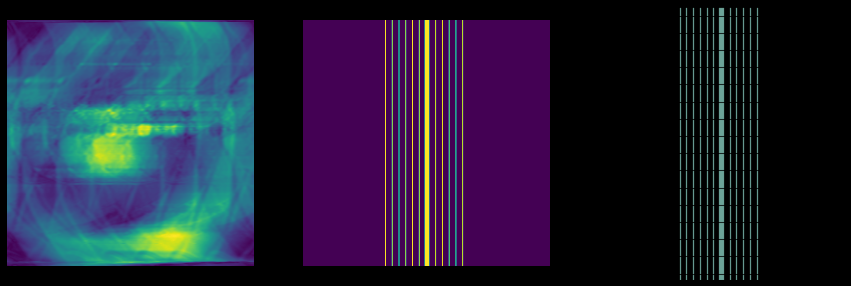

In [5]:
data = next(iter(val_generator))
# data = val_dataset[0]
ishape = data['img'].shape[-2:]


x = torch.arange(-ishape[0]/2, ishape[0]/2, step=1).float()

y = torch.cat([
    torch.arange(-ishape[0]//6, -2, step=7), 
    torch.arange(-2, 2, step=1),
    torch.arange(2, ishape[0]//6, step=7)
]).float()

oshape = [x.shape[0], y.shape[0]]

x, y = torch.meshgrid([x, y])
grid = torch.stack([x.flatten(), y.flatten()])

dcf = ((grid[0]**2 + grid[1]**2)**0.5).reshape(oshape)

img = data['img'] * data['std'] + data['mean']
ks = nufft.nufft(img.cpu(), grid.T, device='cpu').reshape(img.shape[0], img.shape[1], *oshape)
rimg = nufft.nufft_adjoint(ks, grid.T, out_shape=(img.shape[0], img.shape[1], *ishape), device='cpu').abs()
s, m = torch.std_mean(rimg, dim=[-2, -1])
rimg = (rimg - m[:, :, None, None]) / (s[:, :, None, None] + 1e-11)

mask = torch.zeros(ishape)
for i in range(-mask.shape[0]//2, mask.shape[0]//2):
    for j in range(-mask.shape[1]//2, mask.shape[1]//2):
        if (grid[0] - i).abs().min() < 1 and (grid[1] - j).abs().min() < 1:
            mask[i][j] = 1
mask = torch.fft.fftshift(mask)

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(rimg[0,0].cpu())
plt.axis('off')
plt.subplot(132)
plt.imshow(mask)
plt.axis('off')
plt.subplot(133)
plt.scatter(grid[1], grid[0], s=0.1)
plt.xlim(-ishape[0]//2, ishape[0]//2)
plt.ylim(-ishape[1]//2, ishape[1]//2)
plt.axis('off')
plt.show()

# Train sampling

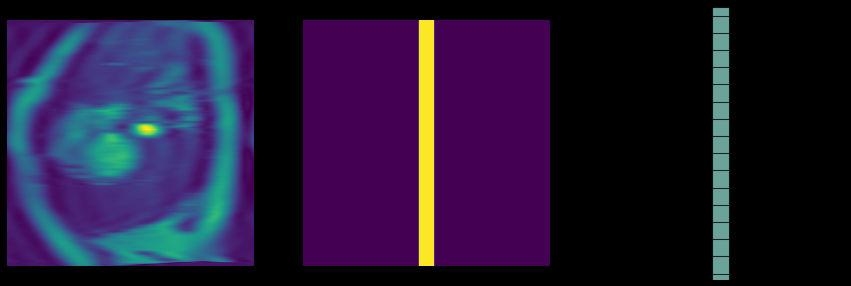

In [6]:
data = next(iter(val_generator))
# data = val_dataset[0]
ishape = data['img'].shape[-2:]

x = torch.arange(-ishape[0]/2, ishape[0]/2, step=1).float()
y = torch.arange(-8, 8, step=1).float()
# y = torch.linspace(-0.071, 0.071, steps=16).float()
oshape = [x.shape[0], y.shape[0]]

X, Y = torch.meshgrid([x, y])
grid = torch.stack([X.flatten(), Y.flatten()])

img = data['img'] * data['std'] + data['mean']
ks = nufft.nufft(img.cpu(), grid.T, device='cpu').reshape(img.shape[0], img.shape[1], *oshape)
rimg = nufft.nufft_adjoint(ks, grid.T, out_shape=(img.shape[0], img.shape[1], *ishape), device='cpu').abs()
s, m = torch.std_mean(rimg, dim=[-2, -1])
rimg = (rimg - m[:, :, None, None]) / (s[:, :, None, None] + 1e-11)

mask = torch.zeros(ishape)
for i in range(-mask.shape[0]//2, mask.shape[0]//2):
    for j in range(-mask.shape[1]//2, mask.shape[1]//2):
        if (grid[0] - i).abs().min() < 1 and (grid[1] - j).abs().min() < 1:
            mask[i][j] = 1
mask = torch.fft.fftshift(mask)

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(rimg[0,0].cpu())
plt.axis('off')
plt.subplot(132)
plt.imshow(mask)
plt.axis('off')
plt.subplot(133)
plt.scatter(grid[1], grid[0], s=0.1)
plt.xlim(-ishape[0]//2, ishape[0]//2)
plt.ylim(-ishape[1]//2, ishape[1]//2)
plt.axis('off')
plt.show()

tensor([[ -0.0000,  -1.1000,  -4.4000,  -9.9000, -17.6000],
        [ -0.0000,  -1.1000,  -4.4000,  -9.9000, -17.6000],
        [ -0.0000,  -1.1000,  -4.4000,  -9.9000, -17.6000],
        [ -0.0000,  -1.1000,  -4.4000,  -9.9000, -17.6000],
        [ -0.0000,  -1.1000,  -4.4000,  -9.9000, -17.6000],
        [ -0.0000,  -1.1000,  -4.4000,  -9.9000, -17.6000],
        [ -0.0000,  -1.1000,  -4.4000,  -9.9000, -17.6000],
        [ -0.0000,  -1.1000,  -4.4000,  -9.9000, -17.6000]])


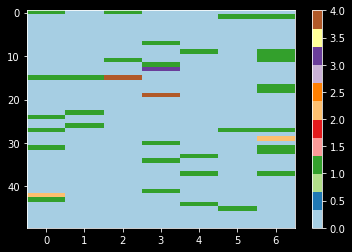

In [7]:
ccl_p = (-1.1 * torch.arange(5).square()).repeat(8, 1)
ccr_p = (-1.1 * torch.arange(5).square()).repeat(7, 1)
print(ccl_p)
ccl_p = -(1 / (ccl_p.softmax(-1) + 1e-2) - 1).log()
ccr_p = -(1 / (ccr_p.softmax(-1) + 1e-2) - 1).log()

plt.imshow(F.gumbel_softmax(ccr_p.detach().cpu().repeat(50, 1, 1)).argmax(-1), 
aspect='auto', vmin=0, vmax=4, cmap=plt.cm.Paired)
plt.colorbar()
plt.show()

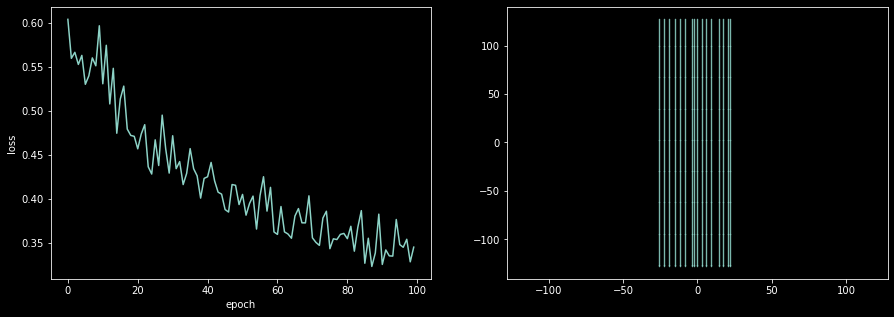

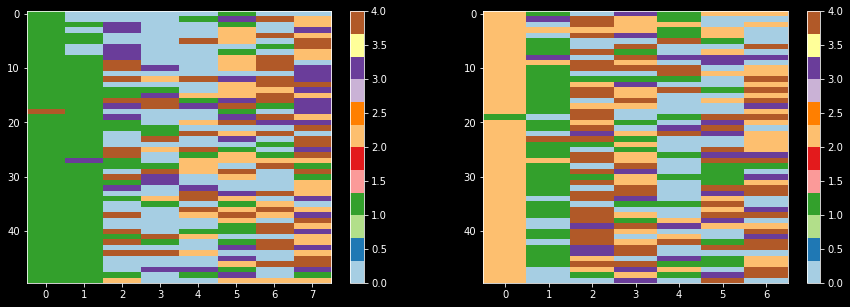

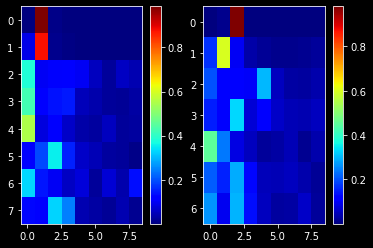

loss: 0.3450750813764684: 100%|██████████| 100/100 [29:10<00:00, 17.50s/it]


In [8]:
import torch_optimizer
from collections import defaultdict
from IPython.display import clear_output
from LBFGS import FullBatchLBFGS

eps = 1e-11

ccl_p = (-0.1 * torch.arange(9).abs()).repeat(8, 1)
ccr_p = (-0.1 * torch.arange(9).abs()).repeat(7, 1)
# ccl_p = torch.randn(8, 9)
# ccr_p = torch.randn(7, 9)

ccl_p = torch.nn.Parameter(data=ccl_p.cuda(), requires_grad=True)
ccr_p = torch.nn.Parameter(data=ccr_p.cuda(), requires_grad=True)

x = x.cuda()
optimizer = torch.optim.Adam([ccl_p, ccr_p], lr=1e-2, weight_decay=0.0)
# optimizer = torch_optimizer.Yogi([ccl_p, ccr_p], lr=1e-3)
# optimizer = FullBatchLBFGS([ccl_p, ccr_p], lr=1, history_size=10, line_search='Wolfe', debug=True)

history = defaultdict(list)

pbar = tqdm(range(100))
for epoch in pbar:
    for data in train_generator:
        # reparam
        ccl = (F.gumbel_softmax(ccl_p, tau=1) * torch.arange(1, 10).float().cuda()[None]).sum(-1)
        ccr = (F.gumbel_softmax(ccr_p, tau=1) * torch.arange(1, 10).float().cuda()[None]).sum(-1)
        # eval grid
        y = torch.cat([-ccl.cumsum(0).flip(0), torch.zeros(1).to(ccr.device), ccr.cumsum(0)])
        X, Y = torch.meshgrid([x, y])
        grid = torch.stack([X.flatten(), Y.flatten()])
        # eval image
        img = data['img'] * data['std'] + data['mean']
        ks = nufft.nufft(img.cuda(), grid.T, device='cuda').reshape(img.shape[0], img.shape[1], *oshape)
        rimg = nufft.nufft_adjoint(ks, grid.T, out_shape=(img.shape[0], img.shape[1], *ishape), device='cuda').abs()
        s, m = torch.std_mean(rimg, dim=[-2, -1])
        rimg = (rimg - m[:, :, None, None]) / (s[:, :, None, None] + 1e-11)
        # eval mask
        loss = dice_loss(data['mask'].long(), model(rimg))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    for data in val_generator:
        with torch.no_grad():
            # reparam
            ccl = (F.gumbel_softmax(ccl_p, tau=1) * torch.arange(1, 10).float().cuda()[None]).sum(-1)
            ccr = (F.gumbel_softmax(ccr_p, tau=1) * torch.arange(1, 10).float().cuda()[None]).sum(-1)
            # eval grid
            y = torch.cat([-ccl.cumsum(0).flip(0), torch.zeros(1).to(ccr.device), ccr.cumsum(0)])
            X, Y = torch.meshgrid([x, y])
            grid = torch.stack([X.flatten(), Y.flatten()])
            # eval image
            img = data['img'] * data['std'] + data['mean']
            ks = nufft.nufft(img.cuda(), grid.T, device='cuda').reshape(img.shape[0], img.shape[1], *oshape)
            rimg = nufft.nufft_adjoint(ks, grid.T, out_shape=(img.shape[0], img.shape[1], *ishape), device='cuda').abs()
            s, m = torch.std_mean(rimg, dim=[-2, -1])
            rimg = (rimg - m[:, :, None, None]) / (s[:, :, None, None] + 1e-11)
            # eval mask
            loss = dice_loss(data['mask'].long(), model(rimg))
            history[epoch].append(loss.item())
    pbar.set_description(f'loss: {np.mean(history[epoch])}')
    clear_output(wait=True)

    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot([np.mean(history[i]) for i in range(len(history))])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.subplot(122)
    plt.scatter(grid[1].detach().cpu(), grid[0].detach().cpu(), s=0.2)
    plt.xlim(-ishape[0]//2, ishape[0]//2)
    plt.show()

    ccl_p_d = ccl_p.detach().cpu().repeat(50, 1, 1)
    ccr_p_d = ccr_p.detach().cpu().repeat(50, 1, 1)

    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.imshow(F.gumbel_softmax(ccl_p_d).argmax(-1), 
    aspect='auto', vmin=0, vmax=4, cmap=plt.cm.Paired)
    plt.colorbar()
    plt.subplot(122)
    plt.imshow(F.gumbel_softmax(ccr_p_d).argmax(-1), 
    aspect='auto', vmin=0, vmax=4, cmap=plt.cm.Paired)
    plt.colorbar()
    plt.show()

    plt.subplot(121)
    plt.imshow(ccl_p.detach().cpu().softmax(-1), aspect='auto', cmap=plt.cm.jet)
    plt.colorbar()
    plt.subplot(122)
    plt.imshow(ccr_p.detach().cpu().softmax(-1), aspect='auto', cmap=plt.cm.jet)
    plt.colorbar()
    plt.show()

In [9]:
# reparam
ccl = torch.arange(1, 10)[ccl_p.detach().softmax(-1).argmax(-1)].cuda()
ccr = torch.arange(1, 10)[ccr_p.detach().softmax(-1).argmax(-1)].cuda()
# eval grid
y = torch.cat([-ccl.cumsum(0).flip(0), torch.zeros(1).to(ccr.device), ccr.cumsum(0)])
X, Y = torch.meshgrid([x, y])
grid = torch.stack([X.flatten(), Y.flatten()])
print(y)

tensor([-14., -11., -10.,  -7.,  -6.,  -5.,  -4.,  -2.,   0.,   3.,   5.,  10.,
         13.,  14.,  17.,  20.], device='cuda:0')


In [10]:
x = torch.arange(-ishape[0]/2, ishape[0]/2, step=1).float()
y = torch.arange(-8, 8, step=1).float()
oshape = [x.shape[0], y.shape[0]]

X, Y = torch.meshgrid([x, y])
_grid = torch.stack([X.flatten(), Y.flatten()])
grid = grid.detach().cpu()

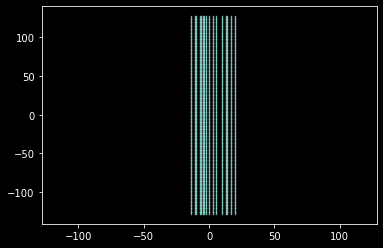

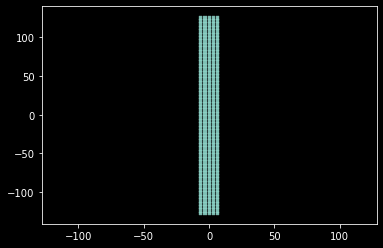

In [11]:
plt.scatter(grid[1], grid[0], s=0.2)
plt.xlim(-ishape[0]//2, ishape[0]//2)
plt.show()

plt.scatter(_grid[1], _grid[0], s=0.2)
plt.xlim(-ishape[0]//2, ishape[0]//2)
plt.show()

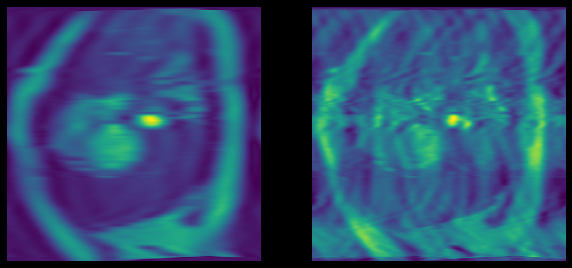

In [12]:
data = next(iter(val_generator))

img = data['img'] * data['std'] + data['mean']
ks = nufft.nufft(img.cpu(), _grid.T, device='cpu').reshape(img.shape[0], img.shape[1], *oshape)
rimg = nufft.nufft_adjoint(ks, _grid.T, out_shape=(img.shape[0], img.shape[1], *ishape), device='cpu').abs()
s, m = torch.std_mean(rimg, dim=[-2, -1])
rimg = (rimg - m[:, :, None, None]) / (s[:, :, None, None] + 1e-11)

plt.figure(figsize=(10,7))
plt.subplot(121)
plt.imshow(rimg[0,0].cpu())
plt.axis('off')

img = data['img'] * data['std'] + data['mean']
ks = nufft.nufft(img.cpu(), grid.T, device='cpu').reshape(img.shape[0], img.shape[1], *oshape)
rimg = nufft.nufft_adjoint(ks, grid.T, out_shape=(img.shape[0], img.shape[1], *ishape), device='cpu').abs()
s, m = torch.std_mean(rimg, dim=[-2, -1])
rimg = (rimg - m[:, :, None, None]) / (s[:, :, None, None] + 1e-11)

plt.subplot(122)
plt.imshow(rimg[0,0].cpu())
plt.axis('off')

plt.show()

In [13]:
grid.shape

torch.Size([2, 4096])

In [14]:
mask = torch.zeros(ishape)
for pi in range(grid.shape[1]):
    i, j = grid[:, pi]
    i = i + ishape[0] // 2
    j = j + ishape[1] // 2
    i = i.item()
    j = j.item()
    mask[int(round(i)), int(round(j))] = 1
# for i in range(-mask.shape[0]//2, mask.shape[0]//2):
#     for j in range(-mask.shape[1]//2, mask.shape[1]//2):
#         if (grid[0] - i).abs().min() < 1 and (grid[1] - j).abs().min() < 1:
#             mask[i][j] = 1
# mask = torch.fft.fftshift(mask)

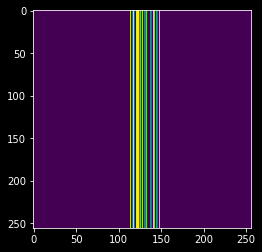

In [15]:
plt.imshow(mask)
plt.show()

In [16]:
mask[0].norm(p=0)

tensor(16.)

In [17]:
torch.save(mask[0], 'patterns/pilot_d_16_1d_1coils_acdc.pt')
torch.save(grid, 'pilot_d_grid.pt')